# 机器学习的工作流程

我们在**拿到一个机器学习问题之后，要做的第一件事就是制作出我们的机器学习项目清单**。下面给出了一个可供参考的机器学习项目清单，它应该适用于大多数机器学习项目，虽然确切的实现细节可能有所不同，但机器学习项目的一般结构保持相对一致：

1. 数据清理和格式化

2. 探索性数据分析

3. 特征工程和特征选择

4. 基于性能指标比较几种机器学习模型

5. 对最佳模型执行超参数调整

6. 在测试集上评估最佳模型

7. 解释模型结果

8. 得出结论


提前设置机器学习管道结构让我们看到每一步是如何流入另一步的。但是，机器学习管道是一个迭代过程，因此我们并不总是以线性方式遵循这些步骤。我们可能会根据管道下游的结果重新审视上一步。例如，
* 虽然我们可以在构建任何模型之前执行特征选择，但我们可以使用建模结果返回并选择一组不同的特征。 
* 或者，建模可能会出现意想不到的结果，这意味着我们希望从另一个角度探索我们的数据。 
* 一般来说，你必须完成一步才能继续下一步，但不要觉得一旦你第一次完成一步，你就不能回头做出改进！你可以在任何时候返回前面的步骤并作出相应的修改

# 项目来源

## 乳腺癌`良/恶`性诊断预测：

乳腺癌威斯康星州（诊断）数据集 预测癌症是良性还是恶性。它由从乳房肿块的细针抽吸物（FNA）的数字化图像计算得出的特征组成。它们描述了图像中存在的细胞核的特征。

### 数据来源： [点这里](https://www.kaggle.com/datasets/roopacalistus/breast-cancer-prediction)



# 导入库

使用标准的数据科学和机器学习库: `numpy, pandas`和`scikit-learn`。使用`matplotlib`和`seaborn`进行可视化。

In [1]:
# 不显示警告
import warnings
warnings.filterwarnings("ignore")

# 对数据操作的库
import numpy as np
import pandas as pd

# 将数据划分为训练集和数据集
from sklearn.model_selection import train_test_split
# 线性回归模型
from sklearn.linear_model import LogisticRegression # 逻辑回归
from sklearn.model_selection import KFold # KFold交叉验证
from sklearn.ensemble import RandomForestClassifier # 随机森林
from sklearn.tree import DecisionTreeClassifier, export_graphviz # 决策树
# 检验机器学习模型效果的各项指标
from sklearn import metrics # 准确度

# 可视化工具包
import matplotlib.pylab as plt
import seaborn as sns
import scipy.stats as stats


In [2]:
import os
for dirname, _, filename in os.walk('/机器学习课程项目/项目'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

## 1.数据清洗和格式化
### 1.1 从原始数据集读入数据并检查（删除第一列id列）

In [3]:
data = pd.read_csv('data/data.csv', index_col=0)
data.head().style.background_gradient(cmap="Pastel1") # 数据集头5行

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
842302,M,17.990000,10.380000,122.800000,1001.000000,0.118400,0.277600,0.300100,0.147100,0.241900,0.078710,1.095000,0.905300,8.589000,153.400000,0.006399,0.049040,0.053730,0.015870,0.030030,0.006193,25.380000,17.330000,184.600000,2019.000000,0.162200,0.665600,0.711900,0.265400,0.460100,0.118900
842517,M,20.570000,17.770000,132.900000,1326.000000,0.084740,0.078640,0.086900,0.070170,0.181200,0.056670,0.543500,0.733900,3.398000,74.080000,0.005225,0.013080,0.018600,0.013400,0.013890,0.003532,24.990000,23.410000,158.800000,1956.000000,0.123800,0.186600,0.241600,0.186000,0.275000,0.089020
84300903,M,19.690000,21.250000,130.000000,1203.000000,0.109600,0.159900,0.197400,0.127900,0.206900,0.059990,0.745600,0.786900,4.585000,94.030000,0.006150,0.040060,0.038320,0.020580,0.022500,0.004571,23.570000,25.530000,152.500000,1709.000000,0.144400,0.424500,0.450400,0.243000,0.361300,0.087580
84348301,M,11.420000,20.380000,77.580000,386.100000,0.142500,0.283900,0.241400,0.105200,0.259700,0.097440,0.495600,1.156000,3.445000,27.230000,0.009110,0.074580,0.056610,0.018670,0.059630,0.009208,14.910000,26.500000,98.870000,567.700000,0.209800,0.866300,0.686900,0.257500,0.663800,0.173000
84358402,M,20.290000,14.340000,135.100000,1297.000000,0.100300,0.132800,0.198000,0.104300,0.180900,0.058830,0.757200,0.781300,5.438000,94.440000,0.011490,0.024610,0.056880,0.018850,0.017560,0.005115,22.540000,16.670000,152.200000,1575.000000,0.137400,0.205000,0.400000,0.162500,0.236400,0.076780


In [4]:
data.tail().style.background_gradient(cmap="Pastel1") # 数据集尾5行

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
926424,M,21.560000,22.390000,142.000000,1479.000000,0.111000,0.115900,0.243900,0.138900,0.172600,0.056230,1.176000,1.256000,7.673000,158.700000,0.010300,0.028910,0.051980,0.024540,0.011140,0.004239,25.450000,26.400000,166.100000,2027.000000,0.141000,0.211300,0.410700,0.221600,0.206000,0.071150
926682,M,20.130000,28.250000,131.200000,1261.000000,0.097800,0.103400,0.144000,0.097910,0.175200,0.055330,0.765500,2.463000,5.203000,99.040000,0.005769,0.024230,0.039500,0.016780,0.018980,0.002498,23.690000,38.250000,155.000000,1731.000000,0.116600,0.192200,0.321500,0.162800,0.257200,0.066370
926954,M,16.600000,28.080000,108.300000,858.100000,0.084550,0.102300,0.092510,0.053020,0.159000,0.056480,0.456400,1.075000,3.425000,48.550000,0.005903,0.037310,0.047300,0.015570,0.013180,0.003892,18.980000,34.120000,126.700000,1124.000000,0.113900,0.309400,0.340300,0.141800,0.221800,0.078200
927241,M,20.600000,29.330000,140.100000,1265.000000,0.117800,0.277000,0.351400,0.152000,0.239700,0.070160,0.726000,1.595000,5.772000,86.220000,0.006522,0.061580,0.071170,0.016640,0.023240,0.006185,25.740000,39.420000,184.600000,1821.000000,0.165000,0.868100,0.938700,0.265000,0.408700,0.124000
92751,B,7.760000,24.540000,47.920000,181.000000,0.052630,0.043620,nan,nan,0.158700,0.058840,0.385700,1.428000,2.548000,19.150000,0.007189,0.004660,nan,nan,0.026760,0.002783,9.456000,30.370000,59.160000,268.600000,0.089960,0.064440,nan,nan,0.287100,0.070390


### 数据说明：
##### 恶性：M - Malignant(cancer)
##### 良性：B - Benign

### 列向量描述：

In [5]:
data.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

### 1.2 数据类型和缺失值

利用`dataframe.info`方法显示每列的数据类型和非缺失值的数量，从而根据数据总量和非缺失值的量判断数据集的缺失值所在的列

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 842302 to 92751
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    object 
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           556 non-null    float64
 8   concave points_mean      556 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se            

由上面数据分析可知，
* 除第一列`diagnosis`外的列数字类型均为float64。因此无需进行数据类型的正确转换，可以直接跳过此步骤。
* 其中有某些列中含有少量缺失值，可以将其填充为0


##### 注:
diagnosis列存放的是良（恶）性诊断结果，所以对后续产生的影响不大，不影响训练结果。

### 1.3 缺失值填充

In [7]:
# 将因变量diagnosis修改为可以操作的数据类型
data['diagnosis'] = data['diagnosis'].astype(str)
data['diagnosis'] = data['diagnosis'].replace({"M":1,"B":0})
data.describe().style.background_gradient(cmap="Blues")

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,556.000000,556.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,556.000000,556.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,556.000000,556.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.090876,0.050063,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.032639,0.012072,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.278553,0.117286,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079468,0.038517,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030136,0.005969,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.206803,0.064087,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000692,0.001852,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000692,0.001852,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.001845,0.008772,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.030880,0.020895,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015620,0.007997,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.121800,0.065713,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.064905,0.034840,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.026245,0.011100,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.231400,0.101700,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.132325,0.074842,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042563,0.014933,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.386200,0.163150,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


In [8]:
# 缺失值填充0值
for j in range(0,31):
    data.iloc[:, j] = data.iloc[:, j].fillna(0)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 842302 to 92751
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   diagnosis                569 non-null    int64  
 1   radius_mean              569 non-null    float64
 2   texture_mean             569 non-null    float64
 3   perimeter_mean           569 non-null    float64
 4   area_mean                569 non-null    float64
 5   smoothness_mean          569 non-null    float64
 6   compactness_mean         569 non-null    float64
 7   concavity_mean           569 non-null    float64
 8   concave points_mean      569 non-null    float64
 9   symmetry_mean            569 non-null    float64
 10  fractal_dimension_mean   569 non-null    float64
 11  radius_se                569 non-null    float64
 12  texture_se               569 non-null    float64
 13  perimeter_se             569 non-null    float64
 14  area_se            

In [10]:
# 数据集尾5行(上面分析可知最后一行有缺失)
data.tail().style.background_gradient(cmap="Pastel1") 

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
926424,1,21.560000,22.390000,142.000000,1479.000000,0.111000,0.115900,0.243900,0.138900,0.172600,0.056230,1.176000,1.256000,7.673000,158.700000,0.010300,0.028910,0.051980,0.024540,0.011140,0.004239,25.450000,26.400000,166.100000,2027.000000,0.141000,0.211300,0.410700,0.221600,0.206000,0.071150
926682,1,20.130000,28.250000,131.200000,1261.000000,0.097800,0.103400,0.144000,0.097910,0.175200,0.055330,0.765500,2.463000,5.203000,99.040000,0.005769,0.024230,0.039500,0.016780,0.018980,0.002498,23.690000,38.250000,155.000000,1731.000000,0.116600,0.192200,0.321500,0.162800,0.257200,0.066370
926954,1,16.600000,28.080000,108.300000,858.100000,0.084550,0.102300,0.092510,0.053020,0.159000,0.056480,0.456400,1.075000,3.425000,48.550000,0.005903,0.037310,0.047300,0.015570,0.013180,0.003892,18.980000,34.120000,126.700000,1124.000000,0.113900,0.309400,0.340300,0.141800,0.221800,0.078200
927241,1,20.600000,29.330000,140.100000,1265.000000,0.117800,0.277000,0.351400,0.152000,0.239700,0.070160,0.726000,1.595000,5.772000,86.220000,0.006522,0.061580,0.071170,0.016640,0.023240,0.006185,25.740000,39.420000,184.600000,1821.000000,0.165000,0.868100,0.938700,0.265000,0.408700,0.124000
92751,0,7.760000,24.540000,47.920000,181.000000,0.052630,0.043620,0.000000,0.000000,0.158700,0.058840,0.385700,1.428000,2.548000,19.150000,0.007189,0.004660,0.000000,0.000000,0.026760,0.002783,9.456000,30.370000,59.160000,268.600000,0.089960,0.064440,0.000000,0.000000,0.287100,0.070390


可见缺失值已经用0值填充。

In [11]:
# 每列的统计信息
data.describe().style.background_gradient(cmap="Reds")

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


### 1.4 切割数据集

由上述分析可知，`data`数据集主要分为`mean、se和worst`三类不同的特征。
假设当前我们并不知道数据集里面的`mean、se和worst`所表达的含义，那我们可以将这三个特征进行切割并做分析。
以下分析中使用的是`mean`进行操作。

In [12]:
data1 = data.loc[:,:'fractal_dimension_mean']
data1.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
id,,,,,,,,,,,
842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


In [13]:
# 每列的统计信息
data1.describe().style.background_gradient(cmap="Reds")

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440


以下分别使用`se`和`worst`进行操作。

In [14]:
data2 = data.loc[:,'radius_se':'fractal_dimension_se']
data2.head()

,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se
id,,,,,,,,,,
842302,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193
842517,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532
84300903,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571
84348301,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208
84358402,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115


In [15]:
# 每列的统计信息
data2.describe().style.background_gradient(cmap="Blues")

,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795
std,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646
min,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895
25%,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248
50%,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187
75%,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558
max,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840


In [16]:
data3 = data.loc[:,'radius_worst':'fractal_dimension_worst']
data3.head()

,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,
842302,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [17]:
# 每列的统计信息
data3.describe().style.background_gradient(cmap="Greens")

,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


## 2. 探索性数据分析
### 2.1 单变量图
由于对数据集中乳腺癌的`良/恶`性进行直方图的绘制，以**检查此变量在数据集中的分布**。

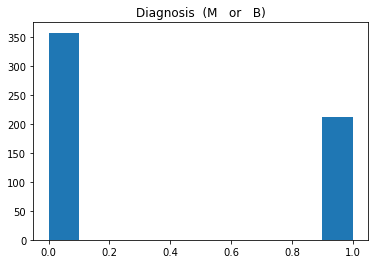

In [18]:
plt.hist(data1['diagnosis'])
plt.title('Diagnosis  (M   or   B)')
plt.show()

### 2.2 多变量图
通过对`data1`数据集`mean`特征中的除`diagnosis`列外的其他列进行绘制直方分布图。

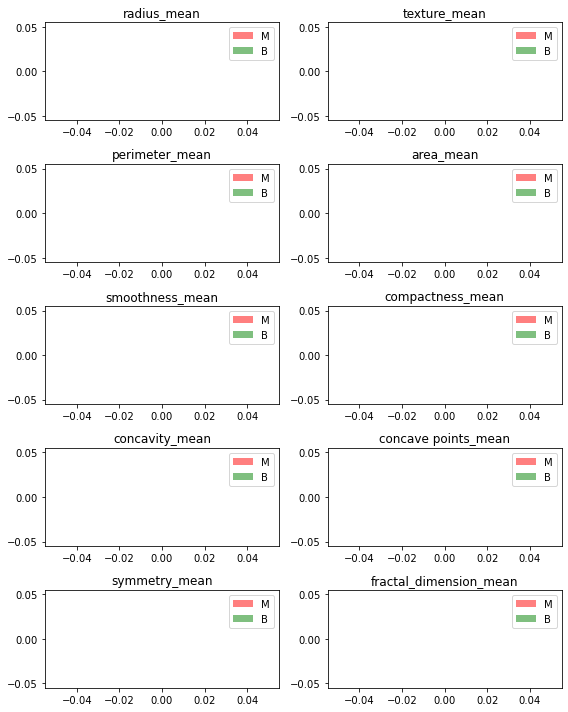

In [19]:
features_mean=list(data1.columns[1:11])
dfM=data[data['diagnosis'] =='M']
dfB=data[data['diagnosis'] =='B']

# 数据堆叠
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(8, 10))
axes = axes.ravel()
for idx,ax in enumerate(axes):
    ax.figure
    binwidth= (max(data1[features_mean[idx]]) - min(data1[features_mean[idx]]))/50
    ax.hist([dfM[features_mean[idx]],dfB[features_mean[idx]]], bins=np.arange(min(data1[features_mean[idx]]), max(data1[features_mean[idx]]) + binwidth, binwidth) , alpha=0.5, stacked=True, density=True, label=['M','B'],color=['r','g'])
    ax.legend(loc='upper right')
    ax.set_title(features_mean[idx])
plt.tight_layout()
plt.show()

同理对`data2`和`data3`进行`se`和`worst`特征的相关操作。

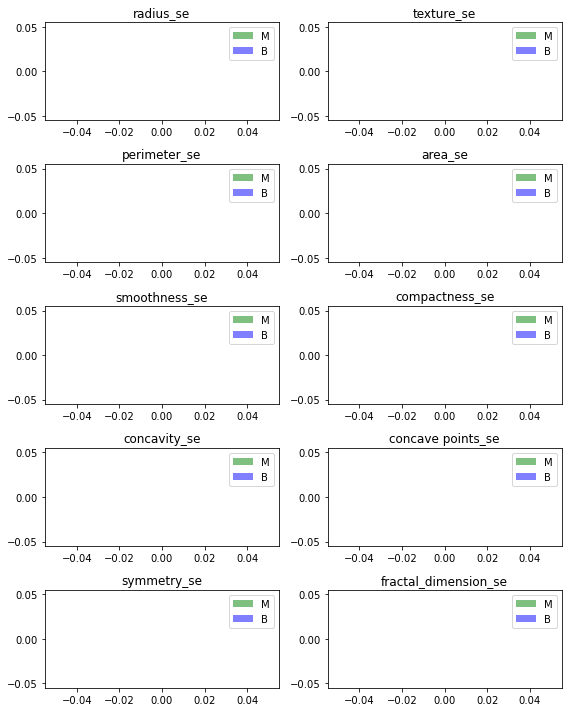

In [20]:
features_se=list(data2.columns[:])

# 数据堆叠
fig2, axes2 = plt.subplots(nrows=5, ncols=2, figsize=(8, 10))
axes2 = axes2.ravel()
for idx,ax in enumerate(axes2):
    ax.figure
    binwidth= (max(data2[features_se[idx]]) - min(data2[features_se[idx]]))/50
    ax.hist([dfM[features_se[idx]],dfB[features_se[idx]]], bins=np.arange(min(data2[features_se[idx]]), max(data2[features_se[idx]]) + binwidth, binwidth) , alpha=0.5, stacked=True, density=True, label=['M','B'],color=['g','b'])
    ax.legend(loc='upper right')
    ax.set_title(features_se[idx])
plt.tight_layout()
plt.show()

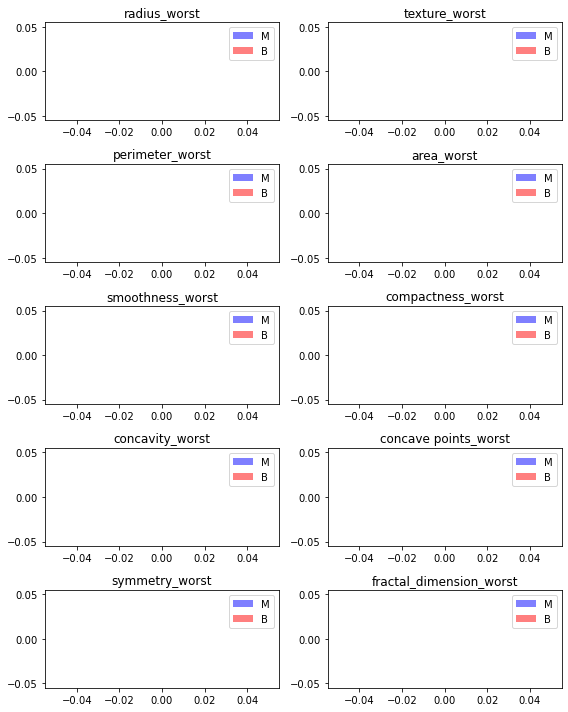

In [21]:
features_worst=list(data3.columns[:])

# 数据堆叠
fig3, axes3 = plt.subplots(nrows=5, ncols=2, figsize=(8, 10))
axes3 = axes3.ravel()
for idx,ax in enumerate(axes3):
    ax.figure
    binwidth= (max(data3[features_worst[idx]]) - min(data3[features_worst[idx]]))/50
    ax.hist([dfM[features_worst[idx]],dfB[features_worst[idx]]], bins=np.arange(min(data3[features_worst[idx]]), max(data3[features_worst[idx]]) + binwidth, binwidth) , alpha=0.5, stacked=True, density=True, label=['M','B'],color=['b','r'])
    ax.legend(loc='upper right')
    ax.set_title(features_worst[idx])
plt.tight_layout()
plt.show()

## 3.特征选择分析
### 3.1 特征选择
由上面的多变量图可知:
1.`mean`和`worst`特征相较于`se`特征更适用于对癌症`良/恶`性进行分类。它们的参数值越大，表现出来的分类效果都比`se`更强，且越倾向于与恶性肿瘤相关。
2.`mean`特征相较于`worst`特征在多变量图里可以看到，`mean`有着更好的纹理、平滑度、对称性以及整体相似性。而且`mean`特征里的柱状图中，没有值得进一步清理的明显的大异常值，相较于`worst`里部分柱状图显得较为自然，如`concave points`。
#### 综上所述，我们选择`mean`特征部分作为机器学习模型的数据来源。
### 3.2 特征部分划分测试集和训练集
由于数据集不是有序的，所以这里简单采用8:2把数据集划分为训练集和测试集。

In [22]:
data_train, data_test = train_test_split(data1, test_size=0.3)
data_train.describe().style.background_gradient(cmap="Reds")

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,0.374372,14.145892,19.234548,92.101407,655.090201,0.096213,0.105035,0.089772,0.048941,0.181216,0.062843
std,0.484569,3.477137,4.398423,24.020893,347.493387,0.014262,0.054526,0.081472,0.039337,0.027239,0.007157
min,0.000000,7.760000,9.710000,47.920000,181.000000,0.052630,0.023440,0.000000,0.000000,0.106000,0.050240
25%,0.000000,11.742500,15.830000,75.472500,423.675000,0.085865,0.062385,0.029890,0.019675,0.162200,0.057670
50%,0.000000,13.400000,18.825000,86.365000,552.050000,0.095820,0.094535,0.058465,0.033245,0.178150,0.061400
75%,1.000000,15.745000,21.895000,103.700000,780.325000,0.104875,0.132950,0.136075,0.073850,0.196500,0.066697
max,1.000000,27.420000,33.810000,186.900000,2501.000000,0.163400,0.311400,0.426800,0.201200,0.304000,0.097440


In [23]:
data_test.describe().style.background_gradient(cmap="Blues")

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
count,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000,171.000000
mean,0.368421,14.084000,19.417895,91.660936,654.421053,0.096703,0.102726,0.086536,0.048869,0.181035,0.062693
std,0.483793,3.640918,4.074993,25.003138,363.031993,0.013627,0.048708,0.075668,0.037645,0.027898,0.006849
min,0.000000,6.981000,10.890000,43.790000,143.500000,0.062510,0.019380,0.000000,0.000000,0.116700,0.049960
25%,0.000000,11.635000,16.845000,74.795000,413.850000,0.086650,0.066670,0.028010,0.020890,0.161700,0.057985
50%,0.000000,13.300000,18.890000,86.100000,546.100000,0.096670,0.090970,0.068770,0.034850,0.180700,0.062010
75%,1.000000,16.135000,21.495000,106.950000,803.600000,0.106050,0.126450,0.121100,0.075450,0.195300,0.065675
max,1.000000,28.110000,39.280000,188.500000,2499.000000,0.132600,0.345400,0.426400,0.191300,0.290600,0.095750


## 4.基于性能指标和交叉验证分数比较几种机器学习模型
下面会构建不同分类模型，并利用训练集对各个分类模型进行性能指标评估。
### 4.1 不同模型分类性能指标展现
构造一个通用的进行分类模型的函数，用于制作分类模型和访问性能评估结果。

来自AnalyticsVidhya教程

    在训练过程中，经常会出现过拟合的问题，就是模型可以很好的匹配训练数据，却不能很好在预测训练集外的数据。如果此时就使用测试数据来调整模型参数，就相当于在训练时已知部分测试数据的信息，会影响最终评估结果的准确性。通常的做法是在训练数据再中分出一部分做为验证(Validation)数据，用来评估模型的训练效果。

    验证数据取自训练数据，但不参与训练，这样可以相对客观的评估模型对于训练集之外数据的匹配程度。
   （[概念来源](https://www.cnblogs.com/xiaosongshine/p/10557891.html)）

In [24]:
def classification_model(model, data, predictors, outcome):
    #拟合模型
    model.fit(data[predictors],data[outcome])
  
    #对测试集进行预测
    predictions = model.predict(data[predictors])
  
    #打印精度
    accuracy = metrics.accuracy_score(predictions,data[outcome])
    print("Accuracy : %s" % "{0:.3%}".format(accuracy))
    
    #执行k-fold交叉验证，共10次
    kf = KFold(n_splits=10, shuffle=True, random_state=1)
    error = []
    for train, test in kf.split(data[error]):
        # 筛选训练数据
        train_predictors = (data[predictors].iloc[train,:])
    
        # 用来训练算法的目标
        train_target = data[outcome].iloc[train]
    
        # 利用预测数据和目标训练
        model.fit(train_predictors, train_target)
    
        # 记录每次交叉验证运行时的错误
        error.append(model.score(data[predictors].iloc[test,:], data[outcome].iloc[test]))
    
        print("model-Selection Score : %s" % "{0:.3%}".format(np.mean(error)))
    
    # 再次拟合模型，便于在函数之外引用
    model.fit(data[predictors],data[outcome]) 

### 4.3 - 需要评估的分类模型
* Logistic Regression model（逻辑回归模型）
* Decision Tree Model（决策树模型）
* Random Forest（随机森林）

#### 逻辑回归
逻辑回归被广泛用于离散数据的分类。在下面，我们将使用它进行二进制(1,0)分类。

根据直方图图的观察，我们可以合理地假设癌症的诊断取决于平均细胞半径、平均周长、平均面积、平均紧实度、平均凹度和平均凹点。然后，我们可以使用以下特征进行逻辑回归分析:

In [25]:
import random
import copy
columns = ['radius_mean','perimeter_mean','area_mean','smoothness_mean',
             'compactness_mean','concavity_mean','concave points_mean',
             'symmetry_mean','fractal_dimension_mean']
# 从列中随机取五个列作为预测器,且保持不变
predictor_0 = random.sample(columns, 5)
predictor = copy.deepcopy(predictor_0)
outcome = 'diagnosis'
model = LogisticRegression()
classification_model(model, data_train, predictor, outcome)

Accuracy : 89.196%
model-Selection Score : 82.500%
model-Selection Score : 87.500%
model-Selection Score : 89.167%
model-Selection Score : 90.625%
model-Selection Score : 90.500%
model-Selection Score : 88.750%
model-Selection Score : 88.929%
model-Selection Score : 89.062%
model-Selection Score : 88.853%
model-Selection Score : 89.199%


可以看出预测精度合理。倘若我们只使用一列数据进行预测呢?下面是只使用一列`radius_mean`作为预测器的情况：

In [26]:
predictor1 = ['radius_mean']
outcome = 'diagnosis'
model = LogisticRegression()
classification_model(model, data_train, predictor1, outcome)

Accuracy : 87.688%
model-Selection Score : 82.500%
model-Selection Score : 85.000%
model-Selection Score : 88.333%
model-Selection Score : 88.750%
model-Selection Score : 88.000%
model-Selection Score : 87.083%
model-Selection Score : 87.500%
model-Selection Score : 87.500%
model-Selection Score : 87.464%
model-Selection Score : 87.692%


可以看到上面两种预测器有着相似的精度和验证分数。
线性回归模型得到的准确性不错，但精度不是很高。让我们看看其他模型的表现。
#### 决策树
决策树模型就是由决策点、策略点(事件点)及结果构成的树形图，一般应用于序列决策中，通常以最大收益期望值或最低期望成本作为决策准则，通过图解方式求解在不同条件下各类方案的效益值，然后通过比较，做出决策。
他是一种简单易用的非参数分类器。它不需要对数据有任何的先验假设，计算速度较快，结果容易解释，而且稳健性强。([来源于](https://baike.baidu.com/item/%E5%86%B3%E7%AD%96%E6%A0%91%E6%A8%A1%E5%9E%8B/17235752))

In [27]:
model = DecisionTreeClassifier()
classification_model(model, data_train, predictor, outcome)

Accuracy : 100.000%
model-Selection Score : 82.500%
model-Selection Score : 86.250%
model-Selection Score : 89.167%
model-Selection Score : 88.750%
model-Selection Score : 87.500%
model-Selection Score : 86.667%
model-Selection Score : 86.786%
model-Selection Score : 87.500%
model-Selection Score : 87.179%
model-Selection Score : 86.923%


可以看到决策树模型计算出来的准确度为100%,但其各项得分并未很接近100,即我们这里是过度拟合了模型，现在猜想其原因是因为预测器里面的数据太多。所以下面是只使用一列`radius_mean`作为预测器的情况：

In [28]:
model = DecisionTreeClassifier()
classification_model(model, data_train, predictor1, outcome)

Accuracy : 96.482%
model-Selection Score : 80.000%
model-Selection Score : 81.250%
model-Selection Score : 85.833%
model-Selection Score : 83.750%
model-Selection Score : 84.000%
model-Selection Score : 82.917%
model-Selection Score : 83.929%
model-Selection Score : 84.062%
model-Selection Score : 84.124%
model-Selection Score : 84.173%


这里准确性相较于`线性回归`要高，可是还未能知道其原因是否取决于预测器。
但我们可以看出单一预测器的交叉验证得分并不高。
#### 随机森林
随机森林指的是利用多棵决策树树对样本进行训练并预测的一种分类器，其输出的类别是由个别树输出的类别的众数而定。([来源于](https://baike.baidu.com/item/%E9%9A%8F%E6%9C%BA%E6%A3%AE%E6%9E%97/1974765))

随机森林的一个优点是它返回一个特征重要性矩阵，可以用来选择特征。所以让我们选择原来随机的5个特征并将其作为预测指标。

In [29]:
# 选择所有特征进行拟合
predictor_all = features_mean
model = RandomForestClassifier(n_estimators=100,min_samples_split=25,
                               max_depth=7, max_features=2)
classification_model(model, data_train, predictor_all, outcome)

Accuracy : 95.226%
model-Selection Score : 90.000%
model-Selection Score : 91.250%
model-Selection Score : 94.167%
model-Selection Score : 94.375%
model-Selection Score : 94.500%
model-Selection Score : 93.333%
model-Selection Score : 93.214%
model-Selection Score : 93.750%
model-Selection Score : 93.305%
model-Selection Score : 93.205%


In [30]:
# 创建一个包含重要特性的序列，使用mean里的所有特征
featimp = pd.Series(model.feature_importances_, index=predictor_all).sort_values(ascending=False)
print(featimp)

concave points_mean       0.281083
perimeter_mean            0.170285
concavity_mean            0.157381
area_mean                 0.145326
radius_mean               0.122099
texture_mean              0.042742
compactness_mean          0.038739
smoothness_mean           0.024048
fractal_dimension_mean    0.010544
symmetry_mean             0.007754
dtype: float64


In [31]:
# 重新选择原本随机的5个特征
model = RandomForestClassifier(n_estimators=100,min_samples_split=25,
                               max_depth=7, max_features=2)
classification_model(model, data_train, predictor_all, outcome)

Accuracy : 95.226%
model-Selection Score : 90.000%
model-Selection Score : 91.250%
model-Selection Score : 93.333%
model-Selection Score : 93.125%
model-Selection Score : 93.500%
model-Selection Score : 92.500%
model-Selection Score : 92.500%
model-Selection Score : 93.125%
model-Selection Score : 92.749%
model-Selection Score : 92.962%


使用前5个特征只会略微改变预测的准确性，但我认为如果使用所有的列预测器会得到更好的结果。

如果我们像之前一样使用单一列的预测器会发生什么?下面只当作验证检查。

In [32]:
model = RandomForestClassifier(n_estimators=100)
classification_model(model, data_train, predictor1, outcome)

Accuracy : 96.482%
model-Selection Score : 80.000%
model-Selection Score : 81.250%
model-Selection Score : 85.833%
model-Selection Score : 84.375%
model-Selection Score : 84.000%
model-Selection Score : 82.917%
model-Selection Score : 83.929%
model-Selection Score : 84.062%
model-Selection Score : 84.124%
model-Selection Score : 83.917%


可以看出单一预测器验证得分并不高，所以认证了使用越多列的预测器可以得到更好的结果。
## 5. 对最佳模型执行超参数调整，即优化模型
在机器学习中，优化模型意味着为特定问题找到最佳的超参数集。
**随机搜索**是指我们选择超参数来评估的方法：

* 我们定义一系列选项，然后随机选择要尝试的组合。 
* 这与网格搜索形成对比，网格搜索评估我们指定的每个组合。

通常，当我们对最佳模型超参数的知识有限时，随机搜索会更好，我们可以使用随机搜索缩小选项范围，然后使用更有限的选项范围进行网格搜索。

### 以下进行对随机森林模型超参数自动择优
([方法来源](https://cloud.tencent.com/developer/article/1829776))

### 5.1整理数据集
分离自变量`diagnosis`和因变量。

In [33]:
# 分离自变量和因变量
train_Y=np.array(data_train['diagnosis'])
train_X=data_train.drop(['diagnosis'],axis=1)
train_X_column_name=list(train_X.columns)
train_X=np.array(train_X)

test_Y=np.array(data_test['diagnosis'])
test_X=data_test.drop(['diagnosis'],axis=1)
test_X=np.array(test_X)
data_train.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,0.374372,14.145892,19.234548,92.101407,655.090201,0.096213,0.105035,0.089772,0.048941,0.181216,0.062843
std,0.484569,3.477137,4.398423,24.020893,347.493387,0.014262,0.054526,0.081472,0.039337,0.027239,0.007157
min,0.000000,7.760000,9.710000,47.920000,181.000000,0.052630,0.023440,0.000000,0.000000,0.106000,0.050240
25%,0.000000,11.742500,15.830000,75.472500,423.675000,0.085865,0.062385,0.029890,0.019675,0.162200,0.057670
50%,0.000000,13.400000,18.825000,86.365000,552.050000,0.095820,0.094535,0.058465,0.033245,0.178150,0.061400
75%,1.000000,15.745000,21.895000,103.700000,780.325000,0.104875,0.132950,0.136075,0.073850,0.196500,0.066697
max,1.000000,27.420000,33.810000,186.900000,2501.000000,0.163400,0.311400,0.426800,0.201200,0.304000,0.097440


### 5.2 超参数范围给定
首先，我们需要对随机森林模型超参数各自的范围加以确定，之后我们将在这些范围内确定各个超参数的最终最优取值。换句话说，我们现在先给每一个需要择优的超参数划定一个很大很大的范围（例如对于“决策树个数”这个超参数，我们可以将其范围划定在10到5000这样一个很大的范围），然后后期将用择优算法在每一个超参数的这个范围内进行搜索。

在此，我们先要确定对哪些超参数进行择优。
  
下面选择在随机森林算法中的几个超参数进行调优，这里选的是评估模型中的四个参数，分别是：决策树个数`n_estimators`，决策树最大深度`max_depth`，最小分离样本数（即拆分决策树节点所需的最小样本数）`min_samples_split`，最大分离特征数（即寻找最佳节点分割时要考虑的特征变量数量）`max_features`。

In [34]:
# 搜索最优超参数
from pprint import pprint
n_estimators_range=[int(x) for x in np.linspace(start=50,stop=3000,num=60)]
max_features_range=['auto','sqrt']
max_depth_range=[int(x) for x in np.linspace(10,500,num=50)]
max_depth_range.append(None)
min_samples_split_range=[2,5,10]

random_forest_hp_range={'n_estimators':n_estimators_range,
                        'max_features':max_features_range,
                        'max_depth':max_depth_range,
                        'min_samples_split':min_samples_split_range
                        }
pprint(random_forest_hp_range)

{'max_depth': [10,
               20,
               30,
               40,
               50,
               60,
               70,
               80,
               90,
               100,
               110,
               120,
               130,
               140,
               150,
               160,
               170,
               180,
               190,
               200,
               210,
               220,
               230,
               240,
               250,
               260,
               270,
               280,
               290,
               300,
               310,
               320,
               330,
               340,
               350,
               360,
               370,
               380,
               390,
               400,
               410,
               420,
               430,
               440,
               450,
               460,
               470,
               480,
               490,
               500,
         

### 5.3 超参数随机匹配择优
接下来将确定的每一种参数**分别组合，对比每一个超参数取值组合所得到的模型结果**，从而决定最优超参数组合。
下面我们会用到
* `RandomizedSearchCV`这一功能——其将随机匹配每一种超参数组合，并输出最优的组合。换句话说，我们用`RandomizedSearchCV`来进行随机的排列，而不是对所有的超参数排列组合方法进行遍历。这样可以节省很多时间。

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

random_seed=40
random_forest_seed=np.random.randint(low=1,high=230)

random_forest_model_test_base=RandomForestClassifier()
random_forest_model_test_random=RandomizedSearchCV(estimator=random_forest_model_test_base,
                                                   param_distributions=random_forest_hp_range,
                                                   n_iter=200,
                                                   n_jobs=-1,
                                                   cv=3,
                                                   verbose=1,
                                                   random_state=random_forest_seed
                                                   )
random_forest_model_test_random.fit(train_X,train_Y)

best_hp_now=random_forest_model_test_random.best_params_
pprint(best_hp_now)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
{'max_depth': 100,
 'max_features': 'sqrt',
 'min_samples_split': 2,
 'n_estimators': 950}


可以看到通过200种匹配方式计算，目前四种超参数最优的组合方式已经得到了。
接下来是对`best_hp_now`所示的结果进行更进一步的择优。
### 5.4 超参数遍历匹配择优
刚刚我们基于`RandomizedSearchCV`实现了200次的超参数随机匹配与择优；但是此时的结果是一个随机不完全遍历后所得的结果，因此其最优组合可能并不是全局最优的，而只是一个大概的最优范围。因此接下来，我们需要依据上述所得到的随机最优匹配结果，进行遍历全部组合的匹配择优。

* 遍历匹配即在随机匹配最优结果的基础上，在其临近范围内选取几个数值，并通过`GridSearchCV`对每一种匹配都遍历，从而选出比较好的超参数最终取值结果。

In [36]:
# 网格搜索

random_forest_hp_range_2={'n_estimators':[200,300,400],
                          'max_features':[9,10],
                          'max_depth':[450,500,550],
                          'min_samples_split':[9,10]
                          }
random_forest_model_test_2_base=RandomForestClassifier()
random_forest_model_test_2_random=GridSearchCV(estimator=random_forest_model_test_2_base,
                                               param_grid=random_forest_hp_range_2,
                                               cv=3,
                                               verbose=1,
                                               n_jobs=-1)
random_forest_model_test_2_random.fit(train_X,train_Y)

best_hp_now_2=random_forest_model_test_2_random.best_params_
pprint(best_hp_now_2)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
{'max_depth': 450,
 'max_features': 10,
 'min_samples_split': 9,
 'n_estimators': 300}


上面是我们经过一次随机择优、一次遍历择优之后的超参数效果，若感觉这个组合搭配不太好可以对上面代码板块运行多次。
#### 经多次运行后，我选择出的参数如下（不代表最优，只是随便选了一个，因为最后结果差距不大）
* 'max_depth': 245
* 'max_features': 9
* 'min_samples_split': 9
* 'n_estimators': 100

### 5.5 模型运行与精度评定
结束了上述超参数择优过程，我们就可以进行模型运行、精度评定与结果输出等操作。

Pearson correlation coefficient is 0.8994708994708995, and RMSE is 0.21629522817435004.


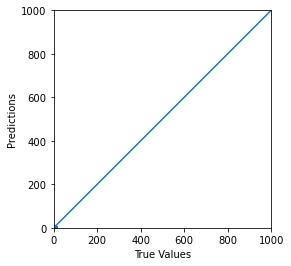

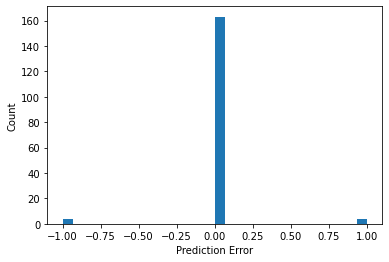

In [37]:
import pydot
from openpyxl import load_workbook
# 将最优超参数组合分配给模型

random_forest_model_final=random_forest_model_test_2_random.best_estimator_

# 预测测试集

random_forest_predict=random_forest_model_test_2_random.predict(test_X)
random_forest_error=random_forest_predict-test_Y

# 绘制测试图

plt.figure(1)
plt.clf()
ax=plt.axes(aspect='equal')
plt.scatter(test_Y,random_forest_predict)
plt.xlabel('True Values')
plt.ylabel('Predictions')
Lims=[0,1000]
plt.xlim(Lims)
plt.ylim(Lims)
plt.plot(Lims,Lims)
plt.grid(False)

plt.figure(2)
plt.clf()
plt.hist(random_forest_error,bins=30)
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.grid(False)

# 验证准确性

random_forest_pearson_r=stats.pearsonr(test_Y,random_forest_predict)
random_forest_R2=metrics.r2_score(test_Y,random_forest_predict)
random_forest_RMSE=metrics.mean_squared_error(test_Y,random_forest_predict)**0.5
print('Pearson correlation coefficient is {0}, and RMSE is {1}.'.format(random_forest_pearson_r[0],
                                                                        random_forest_RMSE))

# 保存关键参数
write_excel_path = 'image/ParameterResult_ML.xlsx'
tree_graph_dot_path='image/tree.dot'
tree_graph_png_path='image/tree.png'
excel_file=load_workbook(write_excel_path)
excel_all_sheet=excel_file.sheetnames
excel_write_sheet=excel_file[excel_all_sheet[0]]
excel_write_sheet=excel_file.active
max_row=excel_write_sheet.max_row
excel_write_content=[random_forest_pearson_r[0],random_forest_R2,random_forest_RMSE,
                     random_seed,random_forest_seed]
for i in range(len(excel_write_content)):
        exec("excel_write_sheet.cell(max_row+1,i+1).value=excel_write_content[i]")
excel_file.save(write_excel_path)

由上面分析可知
* 皮尔逊相关系数（Pearson correlation coefficient）较接近1，则表明预测的准确性与测试集因变量正相关
* 均方根误差（RMSE）值在0.2 - 0.5 之间，说明该模型能够较准确地预测数据。上面RMSE值为0.2，即随机森林可以准确地预测数据。

In [38]:
# 绘制决策树可视化图

random_forest_tree=random_forest_model_final.estimators_[5]
export_graphviz(random_forest_tree,out_file=tree_graph_dot_path,
                feature_names=train_X_column_name,rounded=True,precision=1)
(random_forest_graph,)=pydot.graph_from_dot_file(tree_graph_dot_path)
random_forest_graph.write_png(tree_graph_png_path)

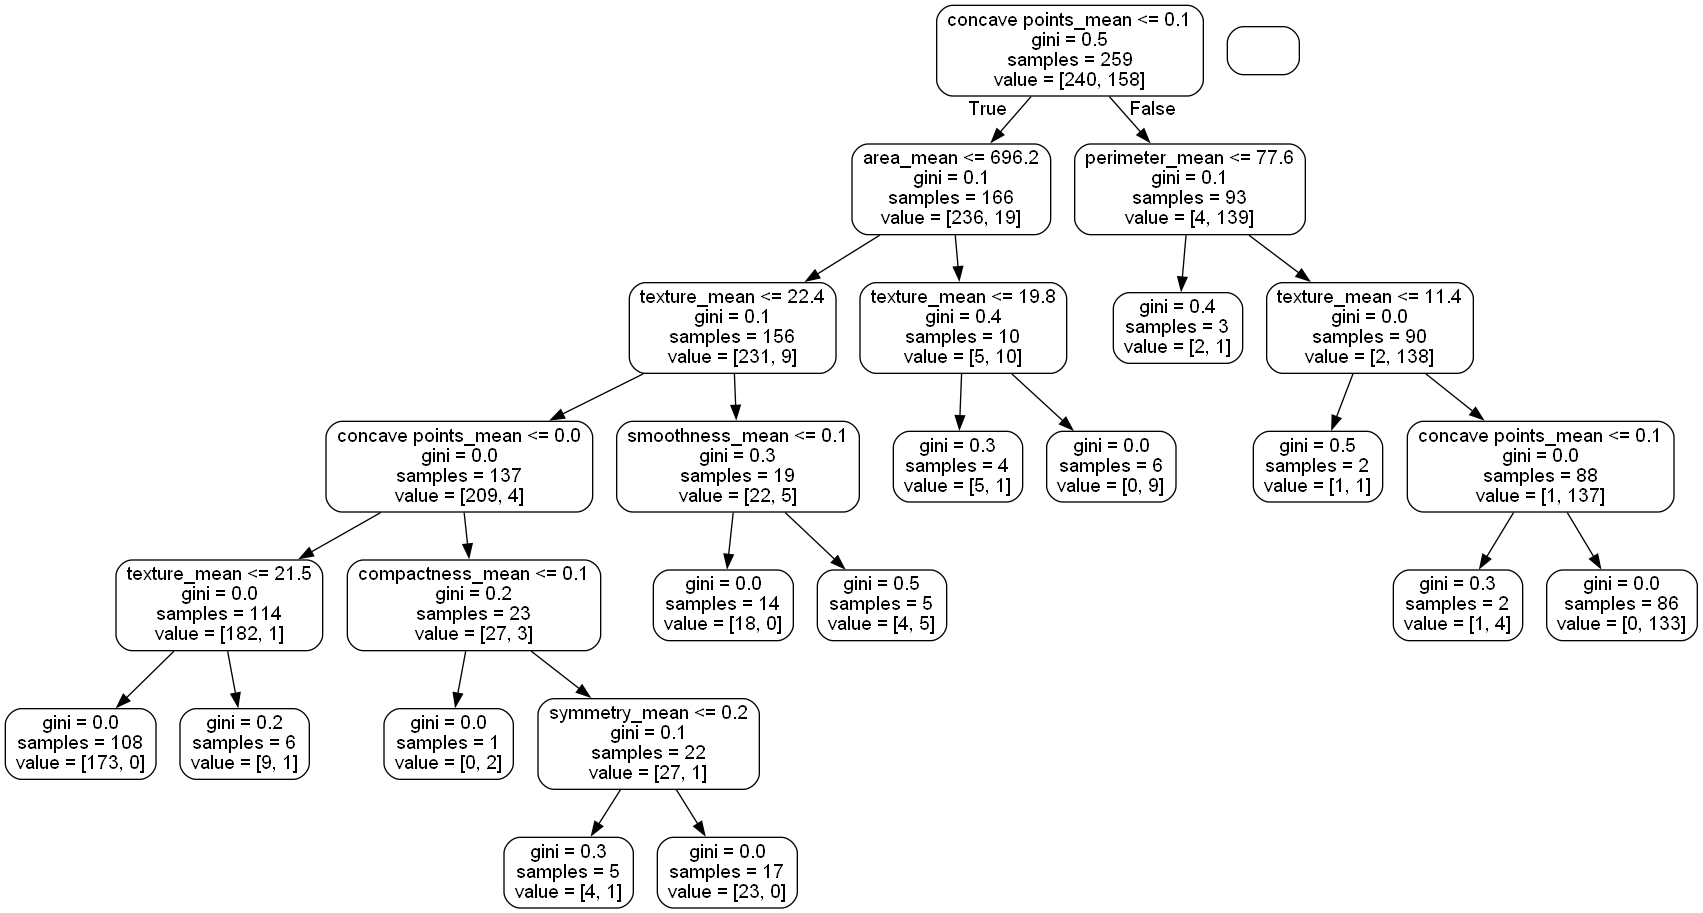

### 5.6 特征重要性
我们可以解释决策树集合的基本方法之一是通过所谓的特征重要性。这些可以解释为最能预测目标的变量。

在scikit-learn中，从训练好的树中提取特征重要性非常容易。 我们将特征重要性存储在数据框中以分析和可视化它们。

Text(0.5, 1.0, 'Variable Importances')

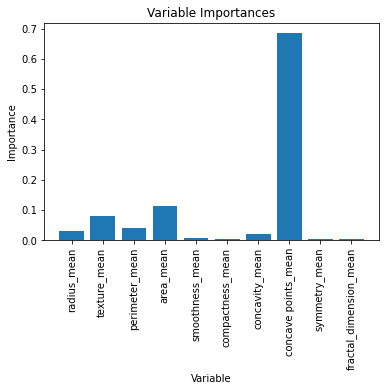

In [39]:
# 计算各特征变量的重要性

random_forest_importance=list(random_forest_model_final.feature_importances_)
random_forest_feature_importance=[(feature,round(importance,8)) 
                                  for feature, importance in zip(train_X_column_name,
                                                                 random_forest_importance)]
random_forest_feature_importance=sorted(random_forest_feature_importance,key=lambda x:x[1],reverse=True)
plt.figure(3)
plt.clf()
importance_plot_x_values=list(range(len(random_forest_importance)))
plt.bar(importance_plot_x_values,random_forest_importance,orientation='vertical')
plt.xticks(importance_plot_x_values,train_X_column_name,rotation='vertical')
plt.xlabel('Variable')
plt.ylabel('Importance')
plt.title('Variable Importances')

可以看到`concave points_mean`这个特征对于预测诊断乳腺癌`良/恶`性影响是最显著的。

## 7. 在测试集上使用最佳模型
由`4.3`即`5.4`里可知，`随机森林`模型对于训练集上的所有特征学习表现最佳，所以我们下面将会利用`随机森林`模型以及超参数化后的参数进行测试集的评估.

In [40]:
# 选择所有特征进行拟合
predictor_all = features_mean
model = RandomForestClassifier(n_estimators=100,min_samples_split=9,
                               max_depth=245, max_features=9)
classification_model(model, data_test, predictor_all, outcome)

Accuracy : 97.661%
model-Selection Score : 94.444%
model-Selection Score : 94.281%
model-Selection Score : 96.187%
model-Selection Score : 92.729%
model-Selection Score : 93.007%
model-Selection Score : 93.192%
model-Selection Score : 94.164%
model-Selection Score : 93.423%
model-Selection Score : 93.500%
model-Selection Score : 92.974%


## 8. 结论


In [41]:
predictor

['radius_mean',
 'fractal_dimension_mean',
 'perimeter_mean',
 'concavity_mean',
 'concave points_mean']

在本分析中发现，用于诊断乳腺癌的最佳模型是随机森林模型，具有如上5个预测因子。对于测试数据集，经过超参数调整后的随机森林模型，它给出了相当高的98-99%的预测精度和93-95%的交叉验证得分。